## Segmentation using UNet
### Imports

In [2]:
import os
import cv2

import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional

import torch.nn as nn
from torch.nn.functional import relu

from PIL import Image

import time
import copy


### Load dataset

In [3]:
class TIFFLoader (Dataset):
    def __init__(self, directory, transform=None):
        # load paths
        self.data_directory = os.path.join(directory, 'data')
        self.label_directory = os.path.join(directory, 'labels')
        self.transform = transform
        self.data_paths = [os.path.join (self.data_directory, file) for file in os.listdir(self.data_directory) if file.endswith('tiff') or file.endswith('tif')]
        self.label_paths = [os.path.join (self.label_directory, file) for file in os.listdir(self.label_directory) if file.endswith('tiff') or file.endswith('tif')]
        # set length
        self.length = len(self.data_paths)

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        data_path = self.data_paths[idx]
        label_path = self.label_paths[idx]
        #with Image.open(data_path) as img:
        #    if self.transform:
        #        data = self.transform(img).to(torch.float)
        #with Image.open(label_path) as img:
        #    if self.transform:
        #        label = self.transform(img).to(torch.float)
        data = self.transform(cv2.resize(cv2.imread(data_path), (496,496)))
        label = self.transform(cv2.resize(cv2.imread(label_path), (496,496)))
        return [data, label]


In [4]:
demo = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())
print(demo.__getitem__(9))

print(demo.length)


[tensor([[[0.5412, 0.5333, 0.5294,  ..., 0.5333, 0.5373, 0.5451],
         [0.5451, 0.5333, 0.5333,  ..., 0.5412, 0.5490, 0.5569],
         [0.5451, 0.5451, 0.5451,  ..., 0.5490, 0.5529, 0.5569],
         ...,
         [0.5373, 0.5294, 0.5255,  ..., 0.6235, 0.6314, 0.6353],
         [0.5294, 0.5255, 0.5255,  ..., 0.6314, 0.6314, 0.6314],
         [0.5216, 0.5176, 0.5216,  ..., 0.6275, 0.6235, 0.6275]],

        [[0.5412, 0.5333, 0.5294,  ..., 0.5333, 0.5373, 0.5451],
         [0.5451, 0.5333, 0.5333,  ..., 0.5412, 0.5490, 0.5569],
         [0.5451, 0.5451, 0.5451,  ..., 0.5490, 0.5529, 0.5569],
         ...,
         [0.5373, 0.5294, 0.5255,  ..., 0.6235, 0.6314, 0.6353],
         [0.5294, 0.5255, 0.5255,  ..., 0.6314, 0.6314, 0.6314],
         [0.5216, 0.5176, 0.5216,  ..., 0.6275, 0.6235, 0.6275]],

        [[0.5412, 0.5333, 0.5294,  ..., 0.5333, 0.5373, 0.5451],
         [0.5451, 0.5333, 0.5333,  ..., 0.5412, 0.5490, 0.5569],
         [0.5451, 0.5451, 0.5451,  ..., 0.5490, 0.5529, 0

### Check for Cuda

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Set up model

In [6]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        # NOTE: changed from (3,64) to (1,64)
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [7]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x

class UNet(nn.Module):
    def __init__(self, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        down_conv_sizes = [(3, 64), (64, 128), (128, 256), (256, 512)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])
        
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])
        
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        
        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.final_conv(x)

        return out

In [8]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

### Run model with data

In [9]:
def get_data_loaders():
    # use the same transformations for train/val in this example
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    # TODO: split up datasets    
    train_set = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())
    val_set = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())

    batch_size = 2

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)
    }

    return dataloaders

In [10]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

In [11]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    dataloaders = get_data_loaders()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)
                    #loss = torch.nn.CrossEntropyLoss(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
dataloaders = get_data_loaders()
for phase in ['train', 'val']:
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

In [13]:
num_class = 3
model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)



Epoch 0/59
----------
LR 0.0001


C:\Users\David\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.691941, dice: 0.495516, loss: 0.593729
val: bce: 0.690710, dice: 0.493085, loss: 0.591897
saving best model
0m 20s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.689157, dice: 0.489599, loss: 0.589378
val: bce: 0.686369, dice: 0.483435, loss: 0.584902
saving best model
0m 18s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.683724, dice: 0.473022, loss: 0.578373
val: bce: 0.680530, dice: 0.452193, loss: 0.566361
saving best model
0m 18s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.693386, dice: 0.419356, loss: 0.556371
val: bce: 0.680876, dice: 0.410791, loss: 0.545834
saving best model
0m 18s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.671102, dice: 0.398010, loss: 0.534556
val: bce: 0.642494, dice: 0.375627, loss: 0.509060
saving best model
0m 18s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.614338, dice: 0.341660, loss: 0.477999
val: bce: 0.551021, dice: 0.373633, loss: 0.462327
saving best model
0m 18s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.547241, dice: 0.3159

In [16]:
torch.save(model.state_dict(), "unet_model.pt")

In [14]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0)) 
print(torch.cuda.max_memory_allocated(0))

389326336
3122689024


In [18]:
# model = torch.load("unet_mode.pt")

UNet(
  (down_conv): ModuleList(
    (0): DoubleConvolution(
      (first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (1): DoubleConvolution(
      (first): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (2): DoubleConvolution(
      (first): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
    (3): DoubleConvolution(
      (first): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act1): ReLU()
      (second): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act2): ReLU()
    )
 

In [28]:
# Set model to the evaluation mode
model.eval()

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
])

# # Create another simulation dataset for test
# TODO: split up datasets    
test_dataset = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/dataset/', transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)



(3, 3, 496, 496)


In [ ]:
# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

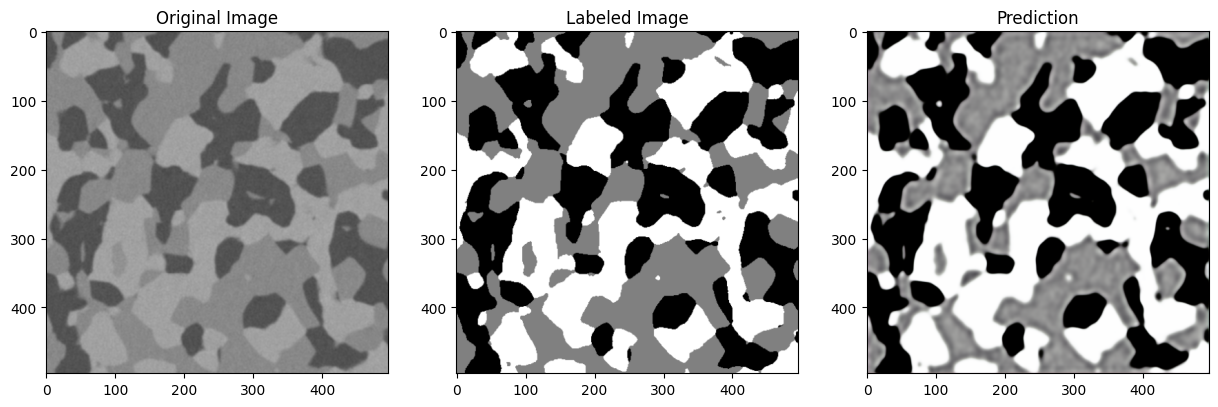

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.imshow(np.swapaxes(inputs[0].cpu(), 0, 2), cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.imshow(np.swapaxes(labels[0].cpu(), 0, 2), cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.imshow(np.swapaxes(pred[0], 0, 2), cmap='gray')
plt.title('Prediction')

# Show the plot
plt.show()